
Required to work:

Plotly (pip install plotly)

pandas_datareader (pip install pandas_datareader)

datetime

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn import preprocessing, svm, cross_validation
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



 Read in data

In [2]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/
end = dt.datetime.now()
start = end - dt.timedelta(days=5*365)

df_tesla = DataReader('TSLA', 'iex', start, end)
df_tesla.index = pd.to_datetime(df_tesla.index, format='%Y-%m-%d')
# Drop row if null
# df_tesla.dropna(inplace=True)


5y


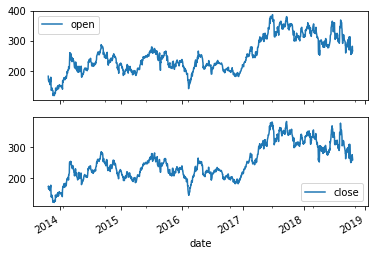

In [3]:

fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

df_tesla[['open']].plot(ax=ax1)
df_tesla[['close']].plot(ax=ax2)

plt.legend(loc=4)

plt.show()

Log feature type 1

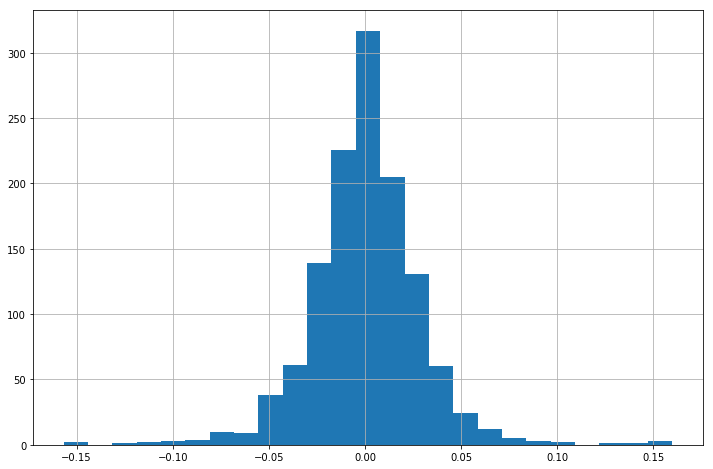

In [4]:
df_tesla['Log_Ret'] = np.log(df_tesla['close'] / df_tesla['close'].shift(1))
df_tesla['Log_Ret'].hist(bins=25, figsize=(12,8))


In [5]:

trace = go.Candlestick(x=df_tesla.index,
                       open=df_tesla.open,
                       high=df_tesla.high,
                       low=df_tesla.low,
                       close=df_tesla.close)

layout = go.Layout(
        xaxis = dict(
        rangeslider = dict(
            visible = False
        )
    )
)

data = [trace]

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename='tesla_candelStick')

In [6]:
# df_tesla.dropna(inplace=True)


Rolling avrage feature type 2

In [7]:
df_tesla['R_AVG'] = df_tesla['close'].rolling(window=5).mean()


BIAS6 feature type 2

In [8]:
df_tesla['R_AVG6'] = df_tesla['close'].rolling(window=6).mean()

df_tesla['BIAS6'] = ((df_tesla['close'] - df_tesla['R_AVG6']) / df_tesla['R_AVG6']) * 100.00


In [9]:
df_tesla.drop(['R_AVG6'], 1, inplace=True)
#df_tesla.dropna(inplace=True)


ROC feature type 1

## $\frac{C_t} {C_{t-14}}×100$

In [45]:
def ROC(df, n):
    M = df['close']
    N = df['close'].shift(n)
    roc = pd.Series(((M / N) * 100), name = 'roc_' + str(n))   
    return roc

roc_series = ROC(df_tesla, 14)

df_tesla['ROC_14'] = roc_series

In [44]:
INCREASING_COLOR = '#00FFFF'
DECREASING_COLOR = '#000000'

In [13]:
data = [ dict(
    type = 'candlestick',
    open = df_tesla.open,
    high = df_tesla.high,
    low = df_tesla.low,
    close = df_tesla.close,
    x = df_tesla.index,
    yaxis = 'y2',
    name = 'GS',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

layout=dict()

fig = dict( data=data, layout=layout )

In [14]:
fig['layout'] = dict()
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )

In [15]:
rangeselector=dict(
    visibe = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector

In [16]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.BIAS6, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = 'darkgreen' ),
                         yaxis = 'y2', name='BIAS6' ) )

In [17]:
colors = []

for i in range(len(df_tesla.close)):
    if i != 0:
        if df_tesla.close[i] > df_tesla.close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

In [18]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.volume,                         
                         marker=dict( color=colors ),
                         type='bar', yaxis='y', name='Volume' ) )

In [19]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.ROC_14, type='scatter', yaxis='y2', 
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), 
                         legendgroup='roc_14', name='roc_14') )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.R_AVG, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='R_AVG', showlegend=True ) )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.Log_Ret, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='Log_Ret', showlegend=True ) )



In [20]:
iplot( fig, filename = 'candlestick_roc_plotting', validate = False )


Regession start

Create data to be passed to Neural network

In [21]:
df = df_tesla.copy()

forecast_col = 'close'
# how many days to forecast
forecast_out = int(10) # I desided to forecast 10 days
print('length =',len(df), "and forecast_out =", forecast_out)

length = 1260 and forecast_out = 10


Shift label with as many says as u wanna forecast

In [22]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [23]:
print(list(df.drop(['label'], 1)))

['open', 'high', 'low', 'close', 'volume', 'Log_Ret', 'R_AVG', 'BIAS6', 'ROC_14']


In [24]:
# Define features Matrix X by excluding the label column
X = np.array(df.dropna().drop(['label'], 1))

# preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.9511145  -1.9264713  -1.97155711 -1.88916193  2.01750657  1.68687316
 -1.79816032 -1.83709131 -1.62689268]


X_forecast_out will exclude the last 10 days that has null data

In [25]:
# X contains last 'n= forecast_out' rows for which we don't have label data

## Du kan nog behålla alla `label` om du gör `dropna()` på passliga ställen

### Förstår ej vad du menar med detta, jag måst ju droppa alla labels från x att inte ge svaren till modellen?

In [26]:
print(X[-forecast_out+2:])

[[ 0.87052574  0.99804779  0.94699995  1.00761263  0.42560238  0.98647983
   0.87324576  0.77308054  0.86978825]
 [ 1.06324108  1.01662223  1.05022381  0.97142095  0.59783726 -0.25650199
   0.90566428  0.43643864  1.51050163]
 [ 0.31552659  0.37502298  0.22533332  0.22035587  7.10076281 -5.36190077
   0.78456223 -3.17867403 -0.81650161]
 [ 0.93821284  0.95551754  0.9459447   1.02728965  4.02990005  5.69289982
   0.82343623  1.10511396  0.96605225]
 [ 1.08165338  1.04925769  0.91213407  0.85722392  1.43446127 -1.14813713
   0.82354206  0.14529365  0.23365288]
 [ 0.89542617  0.83678001  0.77724743  0.74794615  0.46486006 -0.76357576
   0.77140433 -0.35819994  0.06336915]
 [ 0.73094301  0.65277157  0.52989595  0.52007916  0.93542455 -1.6244671
   0.68078063 -1.18684467 -0.55253218]
 [ 0.39250751  0.320862    0.21545705  0.17081193  3.03843231 -2.62972611
   0.67083283 -2.46202766 -1.19279561]]


In [27]:
print(X[:forecast_out+2])

[[-2.03037504 -2.01014307 -2.05661755 -2.00771602  4.21103188 -0.48659161
  -1.69056188 -3.58381788 -2.05472794]
 [-1.9511145  -1.9264713  -1.97155711 -1.88916193  2.01750657  1.68687316
  -1.79816032 -1.83709131 -1.62689268]
 [-1.88640844 -1.93896999 -1.98792858 -2.01035133  2.27295386 -1.76200177
  -1.93577148 -2.04276504 -1.68325968]
 [-1.95392018 -1.97941713 -1.98503688 -1.99453944  1.67107537  0.21427224
  -1.97972521 -0.65012025 -2.03740499]
 [-1.98758838 -2.01361492 -2.02474658 -2.01386509  1.55349477 -0.30241373
  -1.98738713 -0.41902347 -1.94083242]
 [-2.0238869  -2.05614518 -2.02049356 -2.05163795  0.95766018 -0.58038435
  -1.99620609 -0.71951983 -1.74117879]
 [-2.05159302 -2.09954339 -2.2827929  -2.29531684  4.38184749 -3.87498451
  -2.07775684 -3.10634225 -2.63472603]
 [-2.32935563 -2.2115108  -2.28973297 -2.21608167  3.52254889  1.28222988
  -2.11906488 -1.51881499 -2.12549522]
 [-2.21274443 -2.23841769 -2.29258019 -2.30357417  1.97921499 -1.45679858
  -2.18111513 -2.03984

In [28]:
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 10 & Length of X : 1226


In [29]:
# Y get only the labeled data
# X and y lenght should be identical
y = np.array(df.dropna()['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))


Length of y:  1226


In [30]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  980 246


In [31]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((clf.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction


Accuracy of Linear Regression:  0.873502145697947
Coefficients: 
 [-14.98752677  -8.91770274  25.12964519  22.37333815   2.41353661
  -0.27539166  27.97067864   3.2062291   -0.68317124]
Mean squared error: 392.91


In [32]:
forecast_prediction = clf.predict(X_forecast_out)

In [33]:
#df.dropna(inplace=True)
# insert last day of close data to forecast to match the lines
forecast_prediction = np.insert(forecast_prediction, 0, df.iloc[-1].close)


In [34]:
# Plotting data
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [35]:
p1 = go.Scatter(x=df.index,
                y=df.close, 
                mode='lines',
                name='open',
                marker=dict(color='green')
               )
p2 = go.Scatter(x=df.index, 
                y=df.forecast,
                mode='lines',
                name='forecast',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(title='Forecast plot',width=1000,height=1000,
xaxis=dict(title='Date',ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(title='Price',ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[p1, p2], layout=layout)

iplot(fig)

In [36]:
trace1 = go.Scatter(dict(line=dict(color='darkblue'),
                      x=df.index,
                      y=clf.predict(X_test),
                      name='regression( predicted )'))

trace2 = go.Scatter(dict(line=dict(color='green'),
                      x=df.index,
                      y=y_test.flatten(),
                      name='regression ( Y_test/expected )'))



layout = go.Layout(width=1000,height=1000,xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

Testing with ensemble.GradientBoostingRegressor() and ferature testing

In [37]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))


Gradient Boosting R squared": 0.8833


In [38]:
y_pred = model.predict(X_test)
print("Mean squared error: %.2f"
      % np.mean((model.predict(X_test) - y_test) ** 2))


Mean squared error: 362.46


In [39]:
feature_labels = np.array(['open','high','low','close','volume','Log_Ret','R_AVG','BIAS6','ROC_14'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

volume-7.60%
open-7.81%
low-7.98%
high-8.16%
Log_Ret-10.50%
close-12.24%
BIAS6-14.41%
R_AVG-14.68%
ROC_14-16.61%


5 determine buy or sell indicators

In [40]:
df_plot = pd.DataFrame(index=df.index)
df_plot['close'] = df['close']


In [41]:
symbol='TSLA'

df1 = df_plot.rename(columns={'close': symbol})

#df1.dropna(inplace=True)
sma = df1.rolling(window=20).mean()

# calculate the standar deviation
rstd = df1.rolling(window=20).std()

upper_band = sma + 2 * rstd
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * rstd
lower_band = lower_band.rename(columns={symbol: 'lower'})


df2 = df1.join(upper_band).join(lower_band)

#df2.dropna(inplace=True)

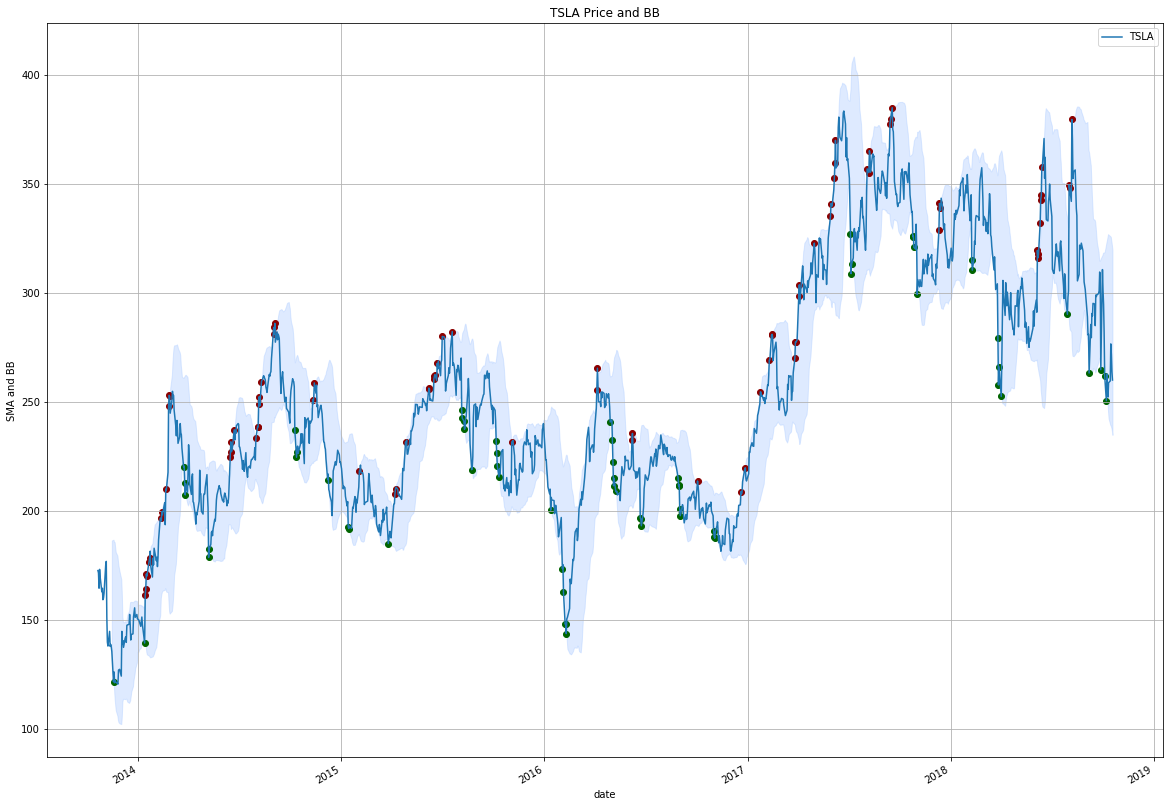

In [42]:
ax0 = df1.plot(title='{} Price and BB'.format(symbol),figsize=(20,15))
ax0.fill_between(df2.index, df2['lower'], df2['upper'], color='#ADCCFF', alpha='0.4')

k = 0
for day, data in df2.iterrows():
    
    if data['TSLA'] > data['upper']:
        #Sell
        ax0.scatter(x=day, y=df2.loc[day, 'TSLA'], color='darkred')

    elif data['TSLA'] < data['lower']:
        #Buy
        ax0.scatter(x=day, y=df2.loc[day, 'TSLA'], color='darkgreen')
    else:
        continue
   
    k = k+1
    
ax0.set_xlabel('date')
ax0.set_ylabel('SMA and BB')
ax0.grid()
plt.show()
